In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from collections import defaultdict
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    confusion_matrix, mean_squared_error, r2_score

In [2]:
df_user = pd.read_csv('takehome_users.csv', encoding = 'iso-8859-1', parse_dates=['creation_time'])
df_engage = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [3]:
df_user.head()

object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2                         0                           0      94   
3                         0                           0       1   
4                         0                           0     193   

   invited_by_user_id  
0             10803.0  
1               316.0  
2              1525.0  
3              5151.0  
4              5240.0

In [4]:
df_user = df_user.rename(columns={'object_id':'user_id'})

In [5]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
# Fill NaNs with 0s to indicate they were not referred by another user.
# Change type to int as they should all be whole numbers, not floats
df_user['invited_by_user_id'] = df_user['invited_by_user_id'].fillna(0)
df_user['invited_by_user_id'] = df_user['invited_by_user_id'].astype(int)

# Fill NaNs with 0s to indicate there is no time available
df_user['last_session_creation_time'] = df_user['last_session_creation_time'].fillna(0)
df_user['last_session_creation_time'] = pd.to_datetime(df_user['last_session_creation_time'], unit='s')

In [7]:
df_user.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [8]:
df_engage.head()

time_stamp  user_id  visited
0 2014-04-22 03:53:30        1        1
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1

In [9]:
df_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [10]:
df_engage.columns

Index(['time_stamp', 'user_id', 'visited'], dtype='object')

In [11]:
# Let's trim out all users who don't at least appear 3 times to limit the amount of data we're working with. 
df = df_engage.groupby('user_id').filter(lambda x: len(x) >= 3)

In [12]:
print(f'This removed {df_engage.shape[0] - df.shape[0]} records from the data.')

This removed 6915 records from the data.


In [13]:
df.head()

time_stamp  user_id  visited
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1
5 2013-12-31 03:45:04        2        1

In [14]:
# count the number of visits per day per user
grouped = df.groupby(['user_id', pd.Grouper(key='time_stamp', freq='D')])['visited'].count()
grouped.head(20)

user_id  time_stamp
2        2013-11-15    1
         2013-11-29    1
         2013-12-09    1
         2013-12-25    1
         2013-12-31    1
         2014-01-08    1
         2014-02-03    1
         2014-02-08    1
         2014-02-09    1
         2014-02-13    1
         2014-02-16    1
         2014-03-09    1
         2014-03-13    1
         2014-03-31    1
10       2013-01-16    1
         2013-01-22    1
         2013-01-30    1
         2013-02-04    1
         2013-02-06    1
         2013-02-14    1
Name: visited, dtype: int64

In [15]:
df.head()

time_stamp  user_id  visited
1 2013-11-15 03:45:04        2        1
2 2013-11-29 03:45:04        2        1
3 2013-12-09 03:45:04        2        1
4 2013-12-25 03:45:04        2        1
5 2013-12-31 03:45:04        2        1

In [16]:
# create dictionary where user_id is key, and list of timestamps are value
usage = defaultdict(list)
for ID, time in zip(df.user_id, df.time_stamp):
    usage[ID].append(time)

In [17]:
usage

defaultdict(list,
            {2: [Timestamp('2013-11-15 03:45:04'),
              Timestamp('2013-11-29 03:45:04'),
              Timestamp('2013-12-09 03:45:04'),
              Timestamp('2013-12-25 03:45:04'),
              Timestamp('2013-12-31 03:45:04'),
              Timestamp('2014-01-08 03:45:04'),
              Timestamp('2014-02-03 03:45:04'),
              Timestamp('2014-02-08 03:45:04'),
              Timestamp('2014-02-09 03:45:04'),
              Timestamp('2014-02-13 03:45:04'),
              Timestamp('2014-02-16 03:45:04'),
              Timestamp('2014-03-09 03:45:04'),
              Timestamp('2014-03-13 03:45:04'),
              Timestamp('2014-03-31 03:45:04')],
             10: [Timestamp('2013-01-16 22:08:03'),
              Timestamp('2013-01-22 22:08:03'),
              Timestamp('2013-01-30 22:08:03'),
              Timestamp('2013-02-04 22:08:03'),
              Timestamp('2013-02-06 22:08:03'),
              Timestamp('2013-02-14 22:08:03'),
              

In [18]:
def within_7days(lst):
    '''takes a list of logins and determines if 2 or more occur in 7 days  '''
    delta_days = [] # list of 2 logins that happend withing 7 days
    for num in range(0, len(lst)-1):
        A = lst[num]
        B = lst[num + 1]
        delta_days.append(np.abs(A - B))
        
    final_lst = [day for day in delta_days if day < timedelta(days = 7)]
    if len(final_lst) > 0:
        return 1
    else:
        return 0

In [19]:
user_adoption = defaultdict(int)
for ID, logs in usage.items():
    if len(logs) < 2:
        user_adoption[ID] = 0
    else:
        user_adoption[ID] = within_7days(logs)

In [20]:
df_user

user_id       creation_time               name  \
0            1 2014-04-22 03:53:30     Clausen August   
1            2 2013-11-15 03:45:04      Poole Matthew   
2            3 2013-03-19 23:14:52  Bottrill Mitchell   
3            4 2013-05-21 08:09:28    Clausen Nicklas   
4            5 2013-01-17 10:14:20          Raw Grace   
...        ...                 ...                ...   
11995    11996 2013-09-06 06:14:15       Meier Sophia   
11996    11997 2013-01-10 18:28:37      Fisher Amelie   
11997    11998 2014-04-27 12:45:16        Haynes Jake   
11998    11999 2012-05-31 11:55:59       Faber Annett   
11999    12000 2014-01-26 08:57:12         Lima Thaís   

                            email     creation_source  \
0        AugustCClausen@yahoo.com        GUEST_INVITE   
1          MatthewPoole@gustr.com          ORG_INVITE   
2      MitchellBottrill@gustr.com          ORG_INVITE   
3       NicklasSClausen@yahoo.com        GUEST_INVITE   
4              GraceRaw@yahoo.com        GUEST_INVITE   
...                           ...                 ...   
11995       SophiaMeier@gustr.com          ORG_INVITE   
11996      AmelieFisher@gmail.com  SIGNUP_GOOGLE_AUTH   
11997         JakeHaynes@cuvox.de        GUEST_INVITE   
11998          mhaerzxp@iuxiw.com   PERSONAL_PROJECTS   
11999   ThaisMeloLima@hotmail.com              SIGNUP   

      last_session_creation_time  opted_in_to_mailing_list  \
0            2014-04-22 03:53:30                         1   
1            2014-03-31 03:45:04                         0   
2            2013-03-19 23:14:52                         0   
3            2013-05-22 08:09:28                         0   
4            2013-01-22 10:14:20                         0   
...                          ...                       ...   
11995        2013-09-06 06:14:15                         0   
11996        2013-01-15 18:28:37                         0   
11997        2014-04-27 12:45:16                         1   
11998        2012-06-02 11:55:59                         0   
11999        2014-01-26 08:57:12                         0   

       enabled_for_marketing_drip  org_id  invited_by_user_id  
0                               0      11               10803  
1                               0       1                 316  
2                               0      94                1525  
3                               0       1                5151  
4                               0     193                5240  
...                           ...     ...                 ...  
11995                           0      89                8263  
11996                           0     200                   0  
11997                           1      83                8074  
11998                           0       6                   0  
11999                           1       0                   0  

[12000 rows x 10 columns]

In [21]:
df_user['adoption'] = [user_adoption[ID] for ID in df_user.user_id]

In [22]:
print(f'Adoption rate is: {round(df_user.adoption.sum() / len(df_user.adoption),2) * 100}%.')

Adoption rate is: 18.0%.


In [23]:
df_user.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adoption'],
      dtype='object')

In [24]:
X = df_user.drop(['name', 'email', 'adoption'], axis=1)
# Create dummies for creation_source
X = pd.get_dummies(X, columns = ['creation_source'])
y = df_user.adoption

X['creation_year'] = X['creation_time'].dt.year
X['creation_month'] = X['creation_time'].dt.month
X['creation_day'] = X['creation_time'].dt.day
X['creation_hour'] = X['creation_time'].dt.hour

# assume df is your pandas DataFrame containing datetime variables
X['last_session_year'] = X['last_session_creation_time'].dt.year
X['last_session_month'] = X['last_session_creation_time'].dt.month
X['last_session_day'] = X['last_session_creation_time'].dt.day
X['last_session_hour'] = X['last_session_creation_time'].dt.hour

# drop the original datetime variables
X.drop(columns=['creation_time','last_session_creation_time'], inplace=True)

# Change uint8 data tpes to int
uint8_cols = X.select_dtypes(include='uint8').columns
X[uint8_cols] = X[uint8_cols].astype('int')

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=123)

In [25]:
# Create a logistic regression object
lr = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)

# Train the model on the training data (scaled data)
lr.fit(X_train, y_train)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test)

# Calculate the metrics
lr_acc = round(accuracy_score(y_test, y_pred),2)
lr_prec = round(precision_score(y_test, y_pred),2)
lr_rec = round(recall_score(y_test, y_pred),2)
lr_f1 = round(f1_score(y_test, y_pred),2)
lr_roc_auc = round(roc_auc_score(y_test, y_pred),2)

# Print the metrics
print("Accuracy:", lr_acc)
print("Precision:", lr_prec)
print("Recall:", lr_rec)
print("F1 score:", lr_f1)
print("ROC-AUC score:", lr_roc_auc)

Accuracy: 0.97
Precision: 0.93
Recall: 0.89
F1 score: 0.91
ROC-AUC score: 0.94


In [26]:
# Look at feature importance
i = 0
features = []
for feature in X.columns.values:
    features.append((lr.coef_[0][i], feature))
    i += 1

top_features = sorted(features, reverse=True)[:5]

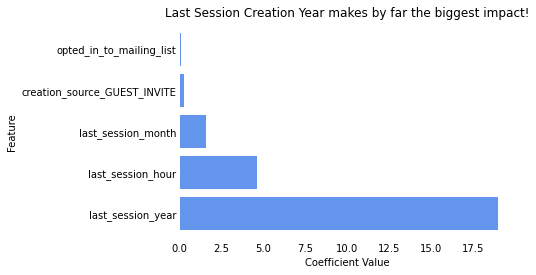

In [27]:
# Extract feature names and coefficients for plotting
feature_names = [f[1] for f in top_features]
coefficients = [f[0] for f in top_features]

# Create horizontal bar plot
plt.barh(feature_names, coefficients, color='cornflowerblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Last Session Creation Year makes by far the biggest impact!')

# Remove the spines of the plot & little ticks on the x-axis & y-axis
sns.despine(bottom=True, left=True)
plt.tick_params(which='both', length=0)

# Show the plot
plt.show()